In [1]:
import boto3

In [2]:
# need to run this from a terminal:
#conda install -c conda-forge poppler

In [ ]:

try:
    from PyPDF2 import PdfFileWriter, PdfFileReader
except:
    !pip install PyPDF2
    from PyPDF2 import PdfFileWriter, PdfFileReader
    
try:
    from pdf2image import convert_from_path
except:
    !pip install pdf2image
    from pdf2image import convert_from_path
    
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

try:
    from trp import Document
except:
    !pip install textract-trp
    from trp import Document

try:
    import tabula
except:
    !pip install tabula-py

!pip install pillow
from PyPDF2 import PdfFileWriter, PdfFileReader

In [4]:

import pandas as pd
import numpy as np
import json
import boto3
from trp import Document
import difflib

%matplotlib inline

In [5]:
pdffile=r"f941.pdf"
#r"UC-CR4 Q2 19 AL SUI-sample3.pdf"
#r"AL UC-CR4 Q4 2019-sample1.pdf",
#r"f941.pdf",
#r"Mississippi 89 140 SIT FLT provided.pdf",
#r"NMDOLES903ATotalsReport.pdf",
#r"Oregon OQ Tax Report Q1 2019-sample2.pdf",
#r"TN LB-0456 Q1 18.pdf",
#r"UC-CR4 Q2 19 AL SUI-sample3.pdf",
#r"Handwritten Sample I9.pdf"

## Convert PDF into Images

In [114]:
pdffile=r"OregonOQ.pdf"
filename=pdffile.split('.')[0]
inputpdf = PdfFileReader(open(pdffile, "rb"))

In [115]:
!rm -r /home/ec2-user/SageMaker/pdf_pages/
!mkdir -p /home/ec2-user/SageMaker/pdf_pages/

In [116]:
# convert pdf document into single page files, then upload to s3 

s3 = boto3.client('s3')
BUCKET = "adptextractpoc"
FOLDER = filename

for i in range(inputpdf.numPages):
    output = PdfFileWriter()
    output.addPage(inputpdf.getPage(i))
    with open("/home/ec2-user/SageMaker/pdf_pages/pdf-page%s.pdf" % i, "wb") as outputStream:
        output.write(outputStream)

    
for i in range(inputpdf.numPages):    
    images = convert_from_path('/home/ec2-user/SageMaker/pdf_pages/pdf-page{}.pdf'.format(i),  500)
    for image in images:
        image.save('/home/ec2-user/SageMaker/pdf_pages/{}-pdf-page{}.jpg'.format(filename,i), 'JPEG')
        s3.upload_file('/home/ec2-user/SageMaker/pdf_pages/{}-pdf-page{}.jpg'.format(filename,i), 
                       Bucket = BUCKET, 
                       Key = '{}/{}-pdf-page{}.jpg'.format(filename,filename,i))



In [117]:
# get rid of local pdf pages
!rm -r /home/ec2-user/SageMaker/pdf_pages/

### no need to run

In [ ]:
ttract_client = boto3.client('textract')

In [ ]:
BUCKET = "wsj-tech-internal"

In [ ]:
line = []
conf = []
line_class = []

for i in range(15):
    print(i)
    KEY    = 'textract/pdf-page{}.jpg'.format(i)
    response = ttract_client.detect_document_text(Document={'S3Object':{'Bucket':BUCKET,'Name':KEY}})
    for block in response['Blocks']:
        if block["BlockType"] == "LINE":
            line.append(block.get("Text", "null"))
            conf.append(block.get("Confidence", "null"))
            line_class.append("bad")

In [ ]:
KEY    = 'textract/pdf-page15.jpg'
response = ttract_client.detect_document_text(Document={'S3Object':{'Bucket':BUCKET,'Name':KEY}})

In [ ]:
line_1 = 0
line_2 = 0
for block in response['Blocks']:
    if (line_1 == 1) & (line_2 == 1):
        if block["BlockType"] == "LINE": 
            line.append(block.get("Text", "null"))
            conf.append(block.get("Confidence", "null"))
            line_class.append("suspect")
    if (line_1 == 0) & (line_2 == 0):
        if block["BlockType"] == "LINE":
            line.append(block.get("Text", "null"))
            conf.append(block.get("Confidence", "null"))
            line_class.append("bad")
            if block.get("Text", "null") == "bytch":
                line_1 = 1
    if (line_1 == 1) & (line_2 == 0):
        if block["BlockType"] == "LINE": 
            if block.get("Text", "null") == "comma-separated list.":
                line_2 = 1

In [ ]:
import pandas as pd

df = pd.DataFrame({'Phrase':line, 'Confidence':conf, 'Type':line_class})
df['Confidence'] = df['Confidence'].astype(float)

In [ ]:
pdffile=r"f941.pdf"
#r"UC-CR4 Q2 19 AL SUI-sample3.pdf"
#r"AL UC-CR4 Q4 2019-sample1.pdf",
#r"f941.pdf",
#r"Mississippi 89 140 SIT FLT provided.pdf",
#r"NMDOLES903ATotalsReport.pdf",
#r"Oregon OQ Tax Report Q1 2019-sample2.pdf",
#r"TN LB-0456 Q1 18.pdf",
#r"UC-CR4 Q2 19 AL SUI-sample3.pdf",
#r"Handwritten Sample I9.pdf"

# Textract Production Model

In [25]:
s3BucketName="adptextractpoc"
documentName="0_AL UC-CR4 Q4 2019-sample1.png"


## 1. raw text extraction

In [6]:
s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"

pageNo=0
pdffile=r"AL UC-CR4 Q4 2019-sample1.pdf"
filename=pdffile.split('.')[0]
documentName='{}/{}-pdf-page{}.jpg'.format(filename,filename,pageNo)


In [7]:
import boto3

# Document
#s3BucketName = "ki-textract-demo-docs"
#documentName = "simple-document-image.jpg"

# Amazon Textract client
textract = boto3.client('textract')

# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "WORD":
        print ('\033[94m' +  item["Text"] + '\033[0m')

FORM
UC
CR4
STATE
OF
ALABAMA
DEPARTMENT
OF
INDUSTRIAL
RELATIONS
UNEMPLOYMENT
COMPENSATION
AGENCY
MONTGOMERY,
ALABAMA
36131
PAGE
1
QUARTERLY
CONTRIBUTION
AND
WAGE
REPORT
Return
page
1
(Contribution
Report)
and
page
2
(Wage
Report)
with
a
remittance
in
the
amount
of
tax
owed.
A
check,
draft
or
money
order
MUST
be
made
payable
to
THE
DEPARTMENT
OF
INDUSTRIAL
RELATIONS
(include
your
employer
account
number
on
the
check,draf
or
money
order).
The
information
gathered
on
this
report
may
be
disclosed
to
other
governmental
agencies
as
authorized
by
law
or
regulation.
Check
here
and
explain
on
page
5
(Employer
Change
Request)
if
there
has
been
a
change
in
ownership,
name,
address
or
primary
business
activity
of
this
unit
during
the
quarter.
0041
-
1800001
TAXPAY
20001
SAMPLE
DAY
LIVING
TEST
INC
1000
ABS
LANE
SUITE
000-
TUSCALOOSA
AL
35405
PAGE
2
MUST
BE
RETURNED
WITH
PAGE
1
This
is
to
certify
that
the
information
in
this
report
is
true
and
correct
to
the
best
of
my
knowledge
REFERENCE
COPY
PREPA

#### write response to json file:

In [12]:
## write response to json file:
with open('{}-page{}.json'.format(filename,pageNo), 'w') as file:
     file.write(json.dumps(response))

#### load existing json file:

In [13]:
## load existing json file:
with open('{}-page{}.json'.format(filename,pageNo)) as json_file: 
    response = json.load(json_file)

In [87]:
## function find Single Word location (X,Y)
WORD2find="35242"
for item in response["Blocks"]:
    if item["BlockType"] == "WORD":
        if item["Text"] == WORD2find:
            print ('\033[94m' +  item["Text"] + '\033[0m')
            
            print(item)
            print(item['Geometry']['Polygon'])
            
            Word_TopLeftX=item['Geometry']['Polygon'][0]['X']
            Word_TopLeftY=item['Geometry']['Polygon'][0]['Y']
            Word_BottomRightX=item['Geometry']['Polygon'][2]['X']
            Word_BottomRightY=item['Geometry']['Polygon'][2]['Y']
            print("TopLeftX:",Word_TopLeftX)
            print("TopLeftY:",Word_TopLeftY)
            print("BottomRightX:",Word_BottomRightX)
            print("BottomRightY:",Word_BottomRightY)

35242
{'BlockType': 'WORD', 'Confidence': 99.89532470703125, 'Text': '35242', 'Geometry': {'BoundingBox': {'Width': 0.04415107145905495, 'Height': 0.010233400389552116, 'Left': 0.27403512597084045, 'Top': 0.9146703481674194}, 'Polygon': [{'X': 0.27403512597084045, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.9249037504196167}, {'X': 0.27403512597084045, 'Y': 0.9249037504196167}]}, 'Id': 'd301cc6b-3dab-43ab-ac03-50e4897f19be'}
[{'X': 0.27403512597084045, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.9249037504196167}, {'X': 0.27403512597084045, 'Y': 0.9249037504196167}]
TopLeftX: 0.27403512597084045
TopLeftY: 0.9146703481674194
BottomRightX: 0.3181861937046051
BottomRightY: 0.9249037504196167


In [88]:
## function found Line contain certain word(s):
WORDS2find="AL 35242"
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        if WORDS2find in item["Text"]:
            print ('\033[94m' +  item["Text"] + '\033[0m')
            
            print(item['Geometry']['Polygon'])
            thisLoc=item['Geometry']['Polygon']
            
            

AL 35242
[{'X': 0.24501186609268188, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.9146703481674194}, {'X': 0.3181861937046051, 'Y': 0.925254225730896}, {'X': 0.24501186609268188, 'Y': 0.925254225730896}]


In [42]:
ABC_loc=thisLoc


In [61]:
AL_loc=thisLoc

In [62]:
ABC_loc

[{'X': 0.06733110547065735, 'Y': 0.8698680996894836},
 {'X': 0.24827411770820618, 'Y': 0.8698680996894836},
 {'X': 0.24827411770820618, 'Y': 0.8806769847869873},
 {'X': 0.06733110547065735, 'Y': 0.8806769847869873}]

In [63]:
AL_loc

[{'X': 0.24501186609268188, 'Y': 0.9146703481674194},
 {'X': 0.3181861937046051, 'Y': 0.9146703481674194},
 {'X': 0.3181861937046051, 'Y': 0.925254225730896},
 {'X': 0.24501186609268188, 'Y': 0.925254225730896}]

In [50]:
ABC_loc[0]

{'X': 0.06733110547065735, 'Y': 0.8698680996894836}

In [51]:
AL_loc[3]

{'X': 0.24501186609268188, 'Y': 0.925254225730896}

In [75]:
TopLX=ABC_loc[0]['X']
TopLY=ABC_loc[0]['Y']
BotRX=AL_loc[2]['X']
BotRY=AL_loc[2]['Y']

In [78]:
## function: Give TopLeftX,TopLeftY, BottomRightX,BottomRightY, 
##           find Lines of words(or Words) in between boundingbox:
#TopX=ABC_loc[0]['X']   #TopX of Word:ABC (can use FINDWord or FINDLine to get)
#TopY=ABC_loc[0]['Y']
#BotX=AL_loc[2]['X']    #BottomX of Word:AL  **3rd element is Bottom Right***
#BotY=AL_loc[2]['Y']

findList=[]
for item in response["Blocks"]:
    if item["BlockType"] == "LINE": #can use WORD
        thisTopLX=item['Geometry']['Polygon'][0]['X']
        thisTopLY=item['Geometry']['Polygon'][0]['Y']
        thisBotRX=item['Geometry']['Polygon'][2]['X']
        thisBotRY=item['Geometry']['Polygon'][2]['Y']
        if thisTopLX>=TopLX and thisTopLY>=TopLY and thisBotRX<=BotRX and thisBotRY<=BotRY:
            findList.append(item['Text'])

In [79]:
findList

['ABC Partners LLC 6401', 'Park SAMPLE Drive', 'Hoover', 'AL 35242']

## 2. form extraction

### use trp library to parse

In [120]:
s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
#documentName="941_2020.png" 

pageNo=0
pdffile=r"NMDOLES903ATotalsReport.pdf"
filename=pdffile.split('.')[0]
documentName='{}/{}-pdf-page{}.jpg'.format(filename,filename,pageNo)
    

In [121]:
import boto3
from trp import Document

# Document
#s3BucketName = "ki-textract-demo-docs"
#documentName = "employmentapp.png"

# Amazon Textract client
textract = boto3.client('textract')

# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

form_kv={}
for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))
        try:
            form_kv[field.key.text]=field.value.text
        except:
            form_kv[field.key.text]=None
        
    # Get field by key
#    print("\nGet Field by Key:")
#    key = "EMPLOYER"
#    field = page.form.getFieldByKey(key)
#    if(field):
#        print("Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
#    print("\nSearch Fields:")
#    key = "Wages"
#    fields = page.form.searchFieldsByKey(key)
#    for field in fields:
#        print("Key: {}, Value: {}".format(field.key, field.value))

Fields:
Key: CRS IDENTIFICATION NUMBER, Value: 0000000
Key: TOTAL TAX RATE, Value: 1.00
Key: EMPLOYER'S NUMBER, Value: 00000000
Key: FEDERAL IRS NUMBER, Value: 00-00000
Key: QUARTER ENDING, Value: 6/30/2019
Key: DUE DATE, Value: 07/31/2019
Key: 8. AMOUNT OF NMDWS REMITTANCE REMITTANCE, Value: 7.30
Key: 1. TOTAL WAGES (TOTAL COLUMN 12), Value: 730.25
Key: OF, Value: 2
Key: TITLE, Value: Payroll
Key: 2. DEDUCT EXCESS WAGES (TOTAL COLUMN 13, Value: 0.00
Key: 4. TOTAL TAX DUE (TAXABLE WAGES X TOTAL TAX RATE, Value: 7.30
Key: 7. LATE PAYMENT PENALTY (ADD 5% OF TAX DUE OR $25.00, WHICHEVER IS GREATER, Value: None
Key: SIGNED, Value: None
Key: FIELD CODE, Value: None
Key: 3. TAXABLE WAGES (ITEM I LESS ITEM 2, Value: 730.25
Key: 6. LATE REPORT PENALTY (ADD, Value: O
Key: 5. INTEREST DUE (1% PER MONTH AFTER DUE, Value: O
Key: DATE, Value: 07/09/2019
Key: PAGE, Value: 1
Key: (Each Employee), Value: $24,800.00


In [122]:
form_kv

{'CRS IDENTIFICATION NUMBER': '0000000',
 'TOTAL TAX RATE': '1.00',
 "EMPLOYER'S NUMBER": '00000000',
 'FEDERAL IRS NUMBER': '00-00000',
 'QUARTER ENDING': '6/30/2019',
 'DUE DATE': '07/31/2019',
 '8. AMOUNT OF NMDWS REMITTANCE REMITTANCE': '7.30',
 '1. TOTAL WAGES (TOTAL COLUMN 12)': '730.25',
 'OF': '2',
 'TITLE': 'Payroll',
 '2. DEDUCT EXCESS WAGES (TOTAL COLUMN 13': '0.00',
 '4. TOTAL TAX DUE (TAXABLE WAGES X TOTAL TAX RATE': '7.30',
 '7. LATE PAYMENT PENALTY (ADD 5% OF TAX DUE OR $25.00, WHICHEVER IS GREATER': None,
 'SIGNED': None,
 'FIELD CODE': None,
 '3. TAXABLE WAGES (ITEM I LESS ITEM 2': '730.25',
 '6. LATE REPORT PENALTY (ADD': 'O',
 '5. INTEREST DUE (1% PER MONTH AFTER DUE': 'O',
 'DATE': '07/09/2019',
 'PAGE': '1',
 '(Each Employee)': '$24,800.00'}

##### save extracted K-V to JSON

In [123]:
with open('{}-page{}-formkv.json'.format(filename,pageNo), 'w') as file:
     file.write(json.dumps(form_kv))

##### edit the JSON in VScode editor, correct each Key and Value format

In [124]:
## load pre-defined correct form: Key-Value(format) json file
with open('NMDOLES903ATotalsReport-page0-formkv-standard.json') as json_file: 
    form_kv_standard = json.load(json_file)

In [125]:
form_kv_standard

{'CRS IDENTIFICATION NUMBER': 'string',
 'TOTAL TAX RATE': 'float',
 "EMPLOYER'S NUMBER": 'string',
 'FEDERAL IRS NUMBER': 'string',
 'QUARTER ENDING': 'date',
 'DUE DATE': 'date',
 '8. AMOUNT OF NMDWS REMITTANCE REMITTANCE': 'float',
 '1. TOTAL WAGES (TOTAL COLUMN 12)': 'float',
 'OF': 'int',
 'TITLE': 'string',
 '2. DEDUCT EXCESS WAGES (TOTAL COLUMN 13': 'float',
 '4. TOTAL TAX DUE (TAXABLE WAGES X TOTAL TAX RATE': 'float',
 '7. LATE PAYMENT PENALTY (ADD 5% OF TAX DUE OR $25.00, WHICHEVER IS GREATER': 'float',
 'SIGNED': 'handwritten signature',
 'FIELD CODE': 'string',
 '3. TAXABLE WAGES (ITEM 1 LESS ITEM 2': 'float',
 '6. LATE REPORT PENALTY (ADD $50.00)': 'float',
 '5. INTEREST DUE (1% PER MONTH AFTER DUE DATE)': 'float',
 'DATE': 'date',
 'PAGE': 'int',
 '(Each Employee)': 'float',
 '1ST MTH.': 'int',
 '2ND MTH.': 'int',
 '3RD MTH.': 'int'}

In [126]:
form_kv

{'CRS IDENTIFICATION NUMBER': '0000000',
 'TOTAL TAX RATE': '1.00',
 "EMPLOYER'S NUMBER": '00000000',
 'FEDERAL IRS NUMBER': '00-00000',
 'QUARTER ENDING': '6/30/2019',
 'DUE DATE': '07/31/2019',
 '8. AMOUNT OF NMDWS REMITTANCE REMITTANCE': '7.30',
 '1. TOTAL WAGES (TOTAL COLUMN 12)': '730.25',
 'OF': '2',
 'TITLE': 'Payroll',
 '2. DEDUCT EXCESS WAGES (TOTAL COLUMN 13': '0.00',
 '4. TOTAL TAX DUE (TAXABLE WAGES X TOTAL TAX RATE': '7.30',
 '7. LATE PAYMENT PENALTY (ADD 5% OF TAX DUE OR $25.00, WHICHEVER IS GREATER': None,
 'SIGNED': None,
 'FIELD CODE': None,
 '3. TAXABLE WAGES (ITEM I LESS ITEM 2': '730.25',
 '6. LATE REPORT PENALTY (ADD': 'O',
 '5. INTEREST DUE (1% PER MONTH AFTER DUE': 'O',
 'DATE': '07/09/2019',
 'PAGE': '1',
 '(Each Employee)': '$24,800.00'}

In [127]:
#### function: correct JSON output Key using predefined Key
## input: form_kv - JSON output extracted Key-Value pair dict
##        form_kv_standard - this specific form pre-defined Key-value(format) dict
## function compare each JSON's Key with predefined Key, and use the close-matched pre-defined key

def form_kv_correction(form_kv,form_kv_standard):
    form_kv_corrected={}
    for key in form_kv.keys():
        this_key_correct_matchlist=difflib.get_close_matches(key,form_kv_standard.keys(), n = 1,cutoff = 0.6)
        if len(this_key_correct_matchlist)>0:
            this_key_correct=this_key_correct_matchlist[0]
            form_kv_corrected[this_key_correct]=form_kv[key]
        else:
            form_kv_corrected[key]="NO_MARTCH_KEY_FOUND"
    for key in form_kv_standard.keys():
        if key not in form_kv_corrected.keys():
            form_kv_corrected[key]="NOT_EXTRACTED_KEY"
    return form_kv_corrected

In [128]:
form_kv_corrected=form_kv_correction(form_kv,form_kv_standard)
form_kv_corrected

{'CRS IDENTIFICATION NUMBER': '0000000',
 'TOTAL TAX RATE': '1.00',
 "EMPLOYER'S NUMBER": '00000000',
 'FEDERAL IRS NUMBER': '00-00000',
 'QUARTER ENDING': '6/30/2019',
 'DUE DATE': '07/31/2019',
 '8. AMOUNT OF NMDWS REMITTANCE REMITTANCE': '7.30',
 '1. TOTAL WAGES (TOTAL COLUMN 12)': '730.25',
 'OF': '2',
 'TITLE': 'Payroll',
 '2. DEDUCT EXCESS WAGES (TOTAL COLUMN 13': '0.00',
 '4. TOTAL TAX DUE (TAXABLE WAGES X TOTAL TAX RATE': '7.30',
 '7. LATE PAYMENT PENALTY (ADD 5% OF TAX DUE OR $25.00, WHICHEVER IS GREATER': None,
 'SIGNED': None,
 'FIELD CODE': None,
 '3. TAXABLE WAGES (ITEM 1 LESS ITEM 2': '730.25',
 '6. LATE REPORT PENALTY (ADD $50.00)': 'O',
 '5. INTEREST DUE (1% PER MONTH AFTER DUE DATE)': 'O',
 'DATE': '07/09/2019',
 'PAGE': '1',
 '(Each Employee)': '$24,800.00',
 '1ST MTH.': 'NOT_EXTRACTED_KEY',
 '2ND MTH.': 'NOT_EXTRACTED_KEY',
 '3RD MTH.': 'NOT_EXTRACTED_KEY'}

In [115]:
form_kv_standard.keys()


dict_keys(['Employer Name and Address', '1. Total Tax Withheld this Period', 'Quarter Ending', '3. Interest', '4. Total Amount Due', 'MS Account ID', 'FEIN', '2. Penalty'])

In [102]:
## sort dictionary by key:
sorted(form_kv_corrected.items(), key = lambda kv:(kv[0]))

[('1 Total Wages Paid THIS QUARTER', '19627.14'),
 ('10 Penalty Due', None),
 ('11 Total Amount Paid', '545.68'),
 ('1ST MO.', '6'),
 ('2 Wages in excess of $8,000 for Calendar year paid to individual workers during THIS QUARTER.',
  '8017.05'),
 ('2ND MO.', '5'),
 ('3 Net Taxable Wages (Item 1 minus Item 2)', '11610.09'),
 ('3RD MO.', '6'),
 ('4 Employer Tax', '538.71'),
 ('5 Employee Tax', None),
 ('6 Employment Security Assessment', '6.97'),
 ('7 Credit Amount.', None),
 ('8 Net Tax Due', '545.68'),
 ('9 If late add interest @ 1% per month', None),
 ('Check here and explain on page 5 (Employer Change Request) if there has been a change in ownership, name, address or primary business activity of this unit during the quarter.',
  'SELECTED'),
 ('Date Due', 'JAN 31, 2020'),
 ('EMPLOYEE', None),
 ('EMPLOYER', None),
 ('Employer Account Number (Must be 1 st 10 Digits)', '00-000000-00'),
 ('For Quarter Ending', 'DEC 31, 2019'),
 ('For State Use Only', None)]

In [95]:
#check float number 
if isinstance(2.3, float): print("YES")   # int for integer 
else: print("NO")
    #check string 
if isinstance('9', str): print("YES")   # int for integer 
else: print("NO")

YES
YES


In [6]:


#Function: input : ,documentName
#          output: extracted form: dataframe of all Key-Value 
def df_form_keyvalue(s3BucketName,documentName):
    textract = boto3.client('textract')
    response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["FORMS"])
    
    doc = Document(response)
    
    df_form=pd.DataFrame(columns=['Key','Value'])
    for page in doc.pages:
         for field in page.form.fields:
            df_form = df_form.append({'Key': field.key, 'Value': field.value}, ignore_index=True)
            
    return df_form

In [7]:
s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
documentName="941_2020.png"
#documentName="941_2020.png" df_form=df_form_keyvalue(doc)
df_form=df_form_keyvalue(s3BucketName,documentName)
df_form

,Key,Value
0,"5e Add Column 2 from lines 5a, 5b, 5c, and 5d 5e","13,408,85"
1,Foreign postal code,None
2,"1 Number of employees who received wages, tips...",16
3,5f Section 3121(q Notice and Demand -Tax due o...,None
4,"6 Total taxes before adjustments. Add lines 3,...","19,109.06"
5,"3 Federal income tax withheld from wages, tips...","5,700.21"
6,Send a refund.,NOT_SELECTED
7,11 Qualified small business payroll tax credit...,None
8,"2 Wages, tips, and other compensation 2","87,639.52"
9,7 Current quarter's adjustment for fractions o...,.09


In [91]:
    df_form=pd.DataFrame(columns=['Key','Value'])
    for page in doc.pages:
         for field in page.form.fields:
            df_form = df_form.append({'Key': field.key, 'Value': field.value}, ignore_index=True)



In [92]:
df_form

,Key,Value
0,5 Employee Tax @ %,None
1,EMPLOYEE,None
2,7 Credit Amount.,None
3,3 Net Taxable Wages (Item 1 minus Item 2),11610.09
4,EMPLOYER,None
5,8 Net Tax Due,545.68
6,11 Total Amount Paid,545.68
7,9 If late add interest @ 1% per month,None
8,"Wages in excess of $8,000 for 2 Calendar year ...",8017.05
9,For Quarter Ending,"DEC 31, 2019"


In [113]:
a0=df_form.iloc[0]['Value'].text
a1=df_form.iloc[1]['Value'].text
a2=df_form.iloc[2]['Value'].text
a3=df_form.iloc[3]['Value'].text

In [114]:
a2l=a2.split(" ")
a2l.insert(2,'.')
''.join(a2l)

'$108.79'

In [121]:
#post processing add . inbetween number & remove space in between number 
# e.g.: $ 108. 79 -> $108.79
#       $ 108 79 -> $108.79
#       $ 00     -> $00
def postporocessing_addDecimalPoint(STR):
    nElementSTR=len(STR.split(" "))
    if STR[0]=='$' and nElementSTR>1:
        if nElementSTR==3 and STR.split(" ")[1][-1]=='.': 
            STR=STR.replace(" ","")   #   $ 108. 79 -> $108.79
        elif nElementSTR==3 and STR.split(" ")[1][-1]!='.':
            STRlist=STR.split(" ")
            STRlist.insert(2,'.')
            STR=''.join(STRlist)   # $ 108 79 -> $108.79
        else:
            STR=STR.replace(" ","")  # $ 00 -> $00
    return STR
        

In [126]:
print(postporocessing_addDecimalPoint(a3))

$


In [131]:
## function find closed match string to a list of string:
# import difflib
# print difflib.get_close_matches(
#    "abcd", ["abc", "acd", "abdc", "dcba"])
#can work with strings (other than single words). In this case, you need to lower the cutoff (the default is 0.6), 
#and raise n, the maximum number of matches:

import difflib
print(difflib.get_close_matches(
 "1ST ",                ["3 Net Taxable Wages (Item 1 minus Item 2)", 
                         "10 Penalty Due", 
                         "dcba",
                         "Credit Amount",
                         "1ST MO",
                         "Employee Tax",
                          "Net Tax Due",
                         "2ND MO."
                       ], n = 4,cutoff = 0.6
                        ))

['1ST MO']


['Employee Tax']


array([<trp.FieldKey object at 0x7fa875e94a58>,
       <trp.FieldKey object at 0x7fa875b84eb8>], dtype=object)

### start from JSON output of Textract

In [30]:
import boto3
import sys
import re
import json


def get_kv_map(file_name):

    with open(file_name, 'rb') as file:
        img_test = file.read()
        bytes_test = bytearray(img_test)
        print('Image loaded', file_name)

    # process using image bytes
    client = boto3.client('textract')
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    # Get the text blocks
    blocks=response['Blocks']
    

    # get key and value maps
    key_map = {}
    value_map = {}
    block_map = {}
    for block in blocks:
        block_id = block['Id']
        block_map[block_id] = block
        if block['BlockType'] == "KEY_VALUE_SET":
            if 'KEY' in block['EntityTypes']:
                key_map[block_id] = block
            else:
                value_map[block_id] = block

    return key_map, value_map, block_map


def get_kv_relationship(key_map, value_map, block_map):
    kvs = {}
    for block_id, key_block in key_map.items():
        value_block = find_value_block(key_block, value_map)
        key = get_text(key_block, block_map)
        val = get_text(value_block, block_map)
        kvs[key] = val
    return kvs


def find_value_block(key_block, value_map):
    for relationship in key_block['Relationships']:
        if relationship['Type'] == 'VALUE':
            for value_id in relationship['Ids']:
                value_block = value_map[value_id]
    return value_block


def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
                    word = blocks_map[child_id]
                    if word['BlockType'] == 'WORD':
                        text += word['Text'] + ' '
                    if word['BlockType'] == 'SELECTION_ELEMENT':
                        if word['SelectionStatus'] == 'SELECTED':
                            text += 'X '    

                                
    return text


def print_kvs(kvs):
    for key, value in kvs.items():
        print(key, ":", value)


def search_value(kvs, search_key):
    for key, value in kvs.items():
        if re.search(search_key, key, re.IGNORECASE):
            return value

def main(file_name):

    key_map, value_map, block_map = get_kv_map(file_name)

    # Get Key Value relationship
    kvs = get_kv_relationship(key_map, value_map, block_map)
    print("\n\n== FOUND KEY : VALUE pairs ===\n")
    print_kvs(kvs)

    # Start searching a key value
    while input('\n Do you want to search a value for a key? (enter "n" for exit) ') != 'n':
        search_key = input('\n Enter a search key:')
        print('The value is:', search_value(kvs, search_key))



In [31]:
file_name='941_2020.png'

In [32]:
key_map, value_map, block_map = get_kv_map(file_name)

Image loaded 941_2020.png


In [33]:
kvs = get_kv_relationship(key_map, value_map, block_map)

In [35]:
print("\n\n== FOUND KEY : VALUE pairs ===\n")
print_kvs(kvs)



== FOUND KEY : VALUE pairs ===

5e Add Column 2 from lines 5a, 5b, 5c, and 5d 5e  : 13,408,85 
Foreign postal code  : 
1 Number of employees who received wages, tips, or other compensation for the pay period including: Mar. 12 (Quarter 1), June 12 (Quarter 2), Sept. 12 (Quarter 3), or Dec. 12 (Quarter 4)  : 16 
5f Section 3121(q Notice and Demand -Tax due on unreported tips (see instructions) 5f  : 
6 Total taxes before adjustments. Add lines 3, 5e, and 5f 6  : 19,109.06 
3 Federal income tax withheld from wages, tips, and other compensation  : 5,700.21 
Send a refund.  : 
11 Qualified small business payroll tax credit for increasing research activities. Attach Form 8974 11  : 
2 Wages, tips, and other compensation 2  : 87,639.52 
7 Current quarter's adjustment for fractions of cents 7  : .09 
Apply to next return.  : 
9 Current quarter's adjustments for tips and group-term life insurance 9  : 
10 Total taxes after adjustments. Combine lines 6 through 9 10  : 19,109.15 
12 Total taxe

In [36]:
while input('\n Do you want to search a value for a key? (enter "n" for exit) ') != 'n':
        search_key = input('\n Enter a search key:')
        print('The value is:', search_value(kvs, search_key))


 Do you want to search a value for a key? (enter "n" for exit) State

 Enter a search key:State
The value is: FL 

 Do you want to search a value for a key? (enter "n" for exit) y

 Enter a search key:Total taxes
The value is: 19,109.06 

 Do you want to search a value for a key? (enter "n" for exit) Subtract line 11

 Enter a search key:Subtract line 11
The value is: 19,109.15 

 Do you want to search a value for a key? (enter "n" for exit) n


In [128]:
kvs

{'5e Add Column 2 from lines 5a, 5b, 5c, and 5d 5e ': '13,408,85 ',
 'Foreign postal code ': '',
 '1 Number of employees who received wages, tips, or other compensation for the pay period including: Mar. 12 (Quarter 1), June 12 (Quarter 2), Sept. 12 (Quarter 3), or Dec. 12 (Quarter 4) ': '16 ',
 '5f Section 3121(q Notice and Demand -Tax due on unreported tips (see instructions) 5f ': '',
 '6 Total taxes before adjustments. Add lines 3, 5e, and 5f 6 ': '19,109.06 ',
 '3 Federal income tax withheld from wages, tips, and other compensation ': '5,700.21 ',
 'Send a refund. ': '',
 '11 Qualified small business payroll tax credit for increasing research activities. Attach Form 8974 11 ': '',
 '2 Wages, tips, and other compensation 2 ': '87,639.52 ',
 "7 Current quarter's adjustment for fractions of cents 7 ": '.09 ',
 'Apply to next return. ': '',
 "9 Current quarter's adjustments for tips and group-term life insurance 9 ": '',
 '10 Total taxes after adjustments. Combine lines 6 through 9 10

In [27]:
def form_kv_from_JSON(response):
    blocks=response['Blocks']
    key_map = {}
    value_map = {}
    block_map = {}
    for block in blocks:
        block_id = block['Id']
        block_map[block_id] = block
        if block['BlockType'] == "KEY_VALUE_SET":
            if 'KEY' in block['EntityTypes']:
                key_map[block_id] = block
            else:
                value_map[block_id] = block
    kvs = {}
    for block_id, key_block in key_map.items():
        value_block = find_value_block(key_block, value_map)
        key = get_text(key_block, block_map)
        val = get_text(value_block, block_map)
        kvs[key] = val
    return kvs

In [28]:
form_kv_from_JSON(response)

{}

## 3. Table extraction

In [10]:
#s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"

s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
#documentName="941_2020.png" 

pageNo=0
pdffile=r"TN LB-0456 Q1 18.pdf"
filename=pdffile.split('.')[0]
documentName='{}/{}-pdf-page{}.jpg'.format(filename,filename,pageNo)
    
    


### use trp library to parse

In [6]:
import boto3
from trp import Document

# Document
#s3BucketName = "ki-textract-demo-docs"
#documentName = "expense.png"

# Amazon Textract client
textract = boto3.client('textract')

# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"])

#print(response)

doc = Document(response)

def isFloat(input):
  try:
    float(input)
  except ValueError:
    return False
  return True

warning = ""
for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            itemName  = ""
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))
                if(c == 0):
                    itemName = cell.text
                elif(c == 4 and isFloat(cell.text)):
                    value = float(cell.text)
                    if(value > 1000):
                        warning += "{} is greater than $1000.".format(itemName)
if(warning):
    print("\nReview needed:\n====================\n" + warning)

Table[0][0] = LAST NAME FIRST INITIAL 
Table[0][1] = NUMBER 
Table[0][2] = DEDUCTIONS 
Table[1][0] = MILLER M 
Table[1][1] = 000-00-0000 
Table[1][2] = 2,769.23 


In [6]:
#Function: input : s3BucketName,documentName
#          output: list dataframe of all tables  
def df_tables(s3BucketName,documentName):
    textract = boto3.client('textract')

    response = textract.analyze_document(
        Document={
            'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
            }
        },
        FeatureTypes=["TABLES"])


    doc = Document(response)

    df_list= []
    for page in doc.pages:
        
        for table in page.tables:
            this_table=[]
            for r, row in enumerate(table.rows):
                itemName  = ""
                thisrow=[]
                for c, cell in enumerate(row.cells):
                    thisrow.append(cell.text)
                this_table.append(thisrow)
                df = pd.DataFrame(this_table)
            df_list.append(df)
    return df_list

In [11]:
df=df_tables(s3BucketName,documentName)
print("Form Name :",pdffile)
print("Page No. :",pageNo+1)
print("Number of Tabels:",len(df))

Form Name : TN LB-0456 Q1 18.pdf
Page No. : 1
Number of Tabels: 2


### Correct OregonOQ.pdf page1 table (4 tables)


##### Table 2: unclear format
##### Table 3: can use Form for Key/Value


##### Correct table 4: 

In [243]:
df_table=pd.DataFrame()
df_table=df[1]
df_table

,0,1,2,3
0,FIRST MONTH (M1),SECOND MONTH (M2),THIRD MONTH (M3),Total (M1 + M2 + M3) Must equal item 5B
1,0.00,0.00,217.67,217.67


In [244]:
#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

# convert dataframe to a list of dict
df_table_dict=df_table.to_dict(orient='records')

# write the list of dict to JSON 
with open('{}-page{}-table4.json'.format(filename,pageNo), 'w') as file:
     json.dump(df_table_dict,file)

# read JSON (table, list of dict), convert to dataFrame 
with open('{}-page{}-table4.json'.format(filename,pageNo)) as json_file: 
    table_json = json.load(json_file)
pd.DataFrame(table_json)

,FIRST MONTH (M1),SECOND MONTH (M2),THIRD MONTH (M3),Total (M1 + M2 + M3) Must equal item 5B
0,0.00,0.00,217.67,217.67


##### Correct Table 1:

In [245]:
df_table=pd.DataFrame()
df_table=df[2]
df_table

,0,1,2,3
0,FIRST MONTH (M1),SECOND MONTH (M2),THIRD MONTH (M3),TOTAL (M1+M2+M3)
1,,1,,1


In [246]:
#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

# convert dataframe to a list of dict
df_table_dict=df_table.to_dict(orient='records')

# write the list of dict to JSON 
with open('{}-page{}-table1.json'.format(filename,pageNo), 'w') as file:
     json.dump(df_table_dict,file)

# read JSON (table, list of dict), convert to dataFrame 
with open('{}-page{}-table1.json'.format(filename,pageNo)) as json_file: 
    table_json = json.load(json_file)
pd.DataFrame(table_json)

,FIRST MONTH (M1),SECOND MONTH (M2),THIRD MONTH (M3),TOTAL (M1+M2+M3)
0,,1,,1


### Correct OregonOQ.pdf page2 table (1 table)



In [8]:
df_table=pd.DataFrame()
df_table=df[0]
df_table

,0,1,2,3,4,5,6
0,,2. Social Security Number,First Initial,3. Employee Last Name,4. Whole Hours Worked,5. Total UI Subject Wages,6. State Withholding Taxes
1,1,000-00-0000,J,Boone,73,2851.60,218
2,2,,,,,,
3,3,,,,,,
4,4,,,,,,
5,5,,,,,,
6,6,,,,,,
7,7,,,,,,
8,8,,,,,,
9,9,,,,,,


In [9]:
#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

#drop column 0 - index 
df_table=df_table.drop(df_table.columns[0], axis=1)
df_table

,2. Social Security Number,First Initial,3. Employee Last Name,4. Whole Hours Worked,5. Total UI Subject Wages,6. State Withholding Taxes
1,000-00-0000,J,Boone,73,2851.60,218
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,
10,,,,,,


####  need to decide last row (21) 

### Correct TN LB-0456 Q1 18.pdf page1 table (2 tables)



#### correct 1st table

In [13]:
df_table=df[0]
df_table

,0,1,2,3,4,5,6
0,STATE ACCOUNT NUMBER,QUARTER/YEAR,QUARTER END DATE,DATE DUE,FEDERAL ID NUMBER,RATE,AREA
1,,1-2018,03-31-2018,14-30-2018,,2.70,


In [14]:
#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

In [15]:
df_table

,STATE ACCOUNT NUMBER,QUARTER/YEAR,QUARTER END DATE,DATE DUE,FEDERAL ID NUMBER,RATE,AREA
1,,1-2018,03-31-2018,14-30-2018,,2.70,


#### !!!! date is not correct, need to check either here or later in final output!!!! 

#### correct 2nd table

In [17]:
df_table=df[1]
df_table

,0,1,2
0,2,2,2
1,,,
2,,DOLLARS,CENTS
3,1 TOTAL WAGES,,28846.20
4,2 LESS EXCESS WAGES,,14846.20
5,3 NET TAXABLE WAGES (ITEM 1 minus ITEM 2),,14000.00
6,4 PREMIUM DUE,,378.00 11
7,(ITEM 3 X .0270),,
8,5 INTEREST DUE,,
9,6 JOB SKILLS FEE DUE,NOT,APPLICABLE


##### !!! need decide the table format (header, columns, index)

#### Correct UC-CR4 Q2 19 AL SUI-sample3.pdf page3 table (1 table)
##### rename column name, write to JSON, and load back as Dataframe

In [188]:
## Correct UC-CR4 Q2 19 AL SUI-sample3.pdf page 3 table
df_table=df[0]

#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

# rename column 
df_table.columns=["NAME OF WORKER", "WORKERS SOCIAL SECIRITY NUMBER","TOTAL WAGES PAID BEFORE DEDUCTIONS"]

## split Name column into two 
df_table=df[0]

#move 1st row as header
df_table.columns = df_table.iloc[0]
df_table=df_table[1:]

# rename column 
df_table.columns=["NAME OF WORKER", "WORKERS SOCIAL SECIRITY NUMBER","TOTAL WAGES PAID BEFORE DEDUCTIONS"]

#no need to run: add a row
#df_table=df_table.append([pd.Series(["ALEX S", "111-11-1111","3,212.32"], index=df_table.columns )],ignore_index=True)


## split Name column into two : Last Name and First Initial
df_table_name = df_table["NAME OF WORKER"].str.split(expand=True)
df_table_name.columns=["NAME OF WORKER.LAST NAME","NAME OF WORKER.FIRST INITIAL"]
df_table_new=pd.concat([df_table_name,df_table[["WORKERS SOCIAL SECIRITY NUMBER","TOTAL WAGES PAID BEFORE DEDUCTIONS"]]],axis=1)

# convert dataframe to a list of dict
df_table_dict=df_table_new.to_dict(orient='records')

# write the list of dict to JSON 
with open('{}-page{}-table.json'.format(filename,pageNo), 'w') as file:
     json.dump(df_table_dict,file)

# read JSON (table, list of dict), convert to dataFrame 
with open('{}-page{}-table.json'.format(filename,pageNo)) as json_file: 
    table_json = json.load(json_file)
pd.DataFrame(table_json)

,NAME OF WORKER.LAST NAME,NAME OF WORKER.FIRST INITIAL,WORKERS SOCIAL SECIRITY NUMBER,TOTAL WAGES PAID BEFORE DEDUCTIONS
0,MILLER,M,000-00-0000,"2,769.23"


In [138]:
## if need nested dict, create nested dict : Name of Worker

for i in range(len(df_table_dict)):
    df_table_dict[i]['NAME of WORKER']={}
    df_table_dict[i]['NAME of WORKER']['LAST NAME']=df_table_dict[i]['NAME OF WORKER.LAST NAME']
    df_table_dict[i]['NAME of WORKER']['FIRST INITIAL']=df_table_dict[i]['NAME OF WORKER.FIRST INITIAL']
    df_table_dict[i].pop('NAME OF WORKER.LAST NAME')
    df_table_dict[i].pop('NAME OF WORKER.FIRST INITIAL')

In [142]:
df_table_dict

[{'WORKERS SOCIAL SECIRITY NUMBER': '000-00-0000 ',
  'TOTAL WAGES PAID BEFORE DEDUCTIONS': '2,769.23 ',
  'NAME of WORKER': {'LAST NAME': 'MILLER', 'FIRST INITIAL': 'M'}},
 {'WORKERS SOCIAL SECIRITY NUMBER': '111-11-1111',
  'TOTAL WAGES PAID BEFORE DEDUCTIONS': '3,212.32',
  'NAME of WORKER': {'LAST NAME': 'ALEX', 'FIRST INITIAL': 'S'}}]

In [144]:
with open('{}-page{}-table.json'.format(filename,pageNo), 'w') as file:
     json.dump(df_table_dict,file)

In [145]:
with open('UC-CR4 Q2 19 AL SUI-sample3-page2-table.json') as json_file: 
    table_json = json.load(json_file)

In [148]:
pd.DataFrame(table_json)

,WORKERS SOCIAL SECIRITY NUMBER,TOTAL WAGES PAID BEFORE DEDUCTIONS,NAME of WORKER
0,000-00-0000,"2,769.23","{'LAST NAME': 'MILLER', 'FIRST INITIAL': 'M'}"
1,111-11-1111,"3,212.32","{'LAST NAME': 'ALEX', 'FIRST INITIAL': 'S'}"


### start from JSON output of Textract

In [44]:
import webbrowser, os
import json
import boto3
import io
from io import BytesIO
import sys
from pprint import pprint


def get_rows_columns_map(table_result, blocks_map):
    rows = {}
    for relationship in table_result['Relationships']:
        if relationship['Type'] == 'CHILD':
            for child_id in relationship['Ids']:
                cell = blocks_map[child_id]
                if cell['BlockType'] == 'CELL':
                    row_index = cell['RowIndex']
                    col_index = cell['ColumnIndex']
                    if row_index not in rows:
                        # create new row
                        rows[row_index] = {}
                        
                    # get the text value
                    rows[row_index][col_index] = get_text(cell, blocks_map)
    return rows


def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
                    word = blocks_map[child_id]
                    if word['BlockType'] == 'WORD':
                        text += word['Text'] + ' '
                    if word['BlockType'] == 'SELECTION_ELEMENT':
                        if word['SelectionStatus'] =='SELECTED':
                            text +=  'X '    
    return text


def get_table_csv_results(file_name):

    with open(file_name, 'rb') as file:
        img_test = file.read()
        bytes_test = bytearray(img_test)
        print('Image loaded', file_name)

    # process using image bytes
    # get the results
    client = boto3.client('textract')

    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['TABLES'])

    # Get the text blocks
    blocks=response['Blocks']
#    pprint(blocks)

    blocks_map = {}
    table_blocks = []
    for block in blocks:
        blocks_map[block['Id']] = block
        if block['BlockType'] == "TABLE":
            table_blocks.append(block)

    if len(table_blocks) <= 0:
        return "<b> NO Table FOUND </b>"

    csv = ''
    for index, table in enumerate(table_blocks):
        csv += generate_table_csv(table, blocks_map, index +1)
        csv += '\n\n'

    return csv

def generate_table_csv(table_result, blocks_map, table_index):
    rows = get_rows_columns_map(table_result, blocks_map)

    table_id = 'Table_' + str(table_index)
    
    # get cells.
    csv = 'Table: {0}\n\n'.format(table_id)

    for row_index, cols in rows.items():
        
        for col_index, text in cols.items():
            csv += '{}'.format(text) + ","
        csv += '\n'
        
    csv += '\n\n\n'
    return csv

def main(file_name):
    table_csv = get_table_csv_results(file_name)

    output_file = 'output.csv'

    # replace content
    with open(output_file, "wt") as fout:
        fout.write(table_csv)

    # show the results
    print('CSV OUTPUT FILE: ', output_file)

In [45]:
file_name

'941_2020.png'

In [46]:
table_csv = get_table_csv_results(file_name)

Image loaded 941_2020.png


In [47]:
print(table_csv)

Table: Table_1

1 Number of employees who received wages, tips, or other compensation for the pay period including: Mar. 12 (Quarter 1), June 12 (Quarter 2), Sept. 12 (Quarter 3), or Dec. 12 (Quarter 4) 1 ,16 ,
2 Wages, tips, and other compensation 2 ,87,639.52 ,
3 Federal income tax withheld from wages, tips, and other compensation 3 ,5,700.21 ,





Table: Table_2

5e Add Column 2 from lines 5a, 5b, 5c, and 5d 5e ,13,408,85 ,
5f Section 3121(q Notice and Demand -Tax due on unreported tips (see instructions) 5f ,,
6 Total taxes before adjustments. Add lines 3, 5e, and 5f 6 ,19,109.06 ,
7 Current quarter's adjustment for fractions of cents 7 ,.09 ,
8 Current quarter's adjustment for sick pay 8 ,,
9 Current quarter's adjustments for tips and group-term life insurance 9 ,,
10 Total taxes after adjustments. Combine lines 6 through 9 10 ,19,109.15 ,
11 Qualified small business payroll tax credit for increasing research activities. Attach Form 8974 11 ,,
12 Total taxes after adjustments and

## Textract Response Parser

###  You can use Textract response parser library to easily parser JSON returned by Amazon Textract. Library parses JSON and provides programming language specific constructs to work with different parts of the document. textractor is an example of PoC batch processing tool that takes advantage of Textract response parser library and generate output in multiple formats.

In [18]:
s3BucketName="adptextractpoc"
#documentName="0_AL UC-CR4 Q4 2019-sample1.png"
documentName="941_2020.png"
#documentName="0_f941_filll.png" 

textract = boto3.client('textract')

# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"]
)


In [19]:
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 0.0, 'Y': 0.0},
     {'X': 1.0, 'Y': 0.0},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': 'd832b034-3492-4062-b7cf-02259a7b490e',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['a452f359-1322-477c-acd1-015f8f6b7be7',
      '7a5e5555-e2fd-4392-ad4b-96bfef48783b',
      '404b0059-70c2-453a-a096-5c1734d21910',
      '3f0a6a9b-4691-4d68-abae-4e8ac9bca13e',
      'd79bdbda-c8bb-4840-a80e-a3f9e69bc0ab',
      '37e4157a-022e-4a5e-84d9-78966a86f7b8',
      '77fc9d5d-c93e-4434-9304-7382fe61d5e1',
      '9b8a0b25-067a-496e-9b34-88d722ab1349',
      '81f718fa-a0b2-4b89-8f01-e142b071055a',
      '4979085a-5edd-449c-b7b2-1e176cd94794',
      'a2315b7d-8e7f-4a14-a0ac-60d10f79a375',
      '25d653f2-169c-46d9-9f1f-932aa5d1acfb',
      '8cd33e96-4197-4bb7-b97d-fa908d16f65b',
      '13ccd1a1

In [20]:
# Call Amazon Textract and get JSON response
#  client = boto3.client('textract')
#  response = client.analyze_document(Document={...}, FeatureTypes=[...])

# Parse JSON response from Textract
doc = Document(response)

# Iterate over elements in the document
for page in doc.pages:
    # Print lines and words
#    for line in page.lines:
#        print("Line: {}--{}".format(line.text, line.confidence))
#        for word in line.words:
#            print("Word: {}--{}".format(word.text, word.confidence))

    # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}-{}".format(r, c, cell.text, cell.confidence))

    # Print fields
    for field in page.form.fields:
        print("Field: Key: {}, Value: {}".format(field.key.text, field.value.text))

    # Get field by key
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

Table[0][0] = 1 Number of employees who received wages, tips, or other compensation for the pay period including: Mar. 12 (Quarter 1), June 12 (Quarter 2), Sept. 12 (Quarter 3), or Dec. 12 (Quarter 4) 1 -99.70372009277344
Table[0][1] = 16 -99.70372009277344
Table[1][0] = 2 Wages, tips, and other compensation 2 -99.70372009277344
Table[1][1] = 87,639.52 -99.70372009277344
Table[2][0] = 3 Federal income tax withheld from wages, tips, and other compensation 3 -99.70372009277344
Table[2][1] = 5,700.21 -99.70372009277344
Table[0][0] = 5e Add Column 2 from lines 5a, 5b, 5c, and 5d 5e -99.69747161865234
Table[0][1] = 13,408,85 -99.69747161865234
Table[1][0] = 5f Section 3121(q Notice and Demand -Tax due on unreported tips (see instructions) 5f -99.69747161865234
Table[1][1] = -99.69747161865234
Table[2][0] = 6 Total taxes before adjustments. Add lines 3, 5e, and 5f 6 -99.69747161865234
Table[2][1] = 19,109.06 -99.69747161865234
Table[3][0] = 7 Current quarter's adjustment for fractions of cen

## Latest Development Model

### Table extraction model

In [5]:
import uuid
import hashlib
import requests
import json
import warnings
 
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
 
 
retry_strategy = Retry(total=3,
                       backoff_factor=0.1,
                       status_forcelist=[500, 502, 503, 504])
 
warnings.filterwarnings('ignore')
class ALICERequestExecutor():
 
    def __init__(self):
        """
        :param logger: logger object required by ALICEClient.
        :param endpoint: string as ALICE endpoint to hit.
        :param region: string as region for S3 resource.
        """
        self._endpoint = 'https://tabledetectortd2-alpha-1500297725.us-east-1.elb.amazonaws.com/theta/invocations'
 
    def _create_payload_data(self, input_bytes):
        request_id = str(uuid.uuid4())
        return {
            'RequestId': request_id,
            'InferenceRequests': [
                {
                    'ImageHash': hashlib.sha256(input_bytes).hexdigest(),
                    'RequestId': request_id,
                }
            ]
        }
 
    def execute(self, input_bytes: bytes) -> bytes:
        """
        Take in image bytes, and Call ALICE client with a new request context.
        :param input_bytes: bytes as image bytes passed to ALICE endpoint.
        :return: bytes as converted response returned from ALICE client.
        """
        session = requests.session()
        session.mount(self.endpoint, HTTPAdapter(max_retries=retry_strategy))
        files = {'uploadfile': input_bytes}
        payload = self._create_payload_data(input_bytes)
        data = {"inference_batch_request": json.dumps(payload)}
        alice_response = session.post(self.endpoint, files=files, data=data, verify=False)
        return alice_response.content
 
    @property
    def endpoint(self):
        return self._endpoint
 
 
if __name__ == '__main__':
    alice_executor = ALICERequestExecutor()
    image_path = '941_2020.png'
    with open(image_path, 'rb') as file:
        bytes = file.read()
    output_bytes  = alice_executor.execute(bytes)
    alice_output = json.loads(output_bytes, encoding='utf-8')
    results = alice_output['InferenceResponses'][0]['Results']
    print(results)

[{'Id': 'c6b53208-74c4-4252-a227-70a2a86ee6fb', 'Type': 'TABLE', 'Geometry': {'BoundingBox': {'Width': 0.92290344, 'Height': 0.09598355, 'Left': 0.04600917, 'Top': 0.32274513}, 'Polygon': {'Points': [{'X': 0.04600917, 'Y': 0.32274513, 'Z': 0.0}, {'X': 0.9689126100000001, 'Y': 0.32274513, 'Z': 0.0}, {'X': 0.9689126100000001, 'Y': 0.41872867999999996, 'Z': 0.0}, {'X': 0.04600917, 'Y': 0.41872867999999996, 'Z': 0.0}]}}, 'Predictions': {'PREDICTION': [{'Name': 'CONF', 'Confidence': 0.9996516704559326}]}, 'Embeddings': {'ROW_SEPS': [0.322745144367218, 0.3581523895263672, 0.3927064538002014, 0.41872867941856384], 'COL_SEPS': [0.04600917175412178, 0.73972487449646, 0.9689126014709473]}, 'Relationships': [{'Type': 'CHILD', 'EntityId': '99de3e3f-bf00-474d-9ea9-26b2deb1367b'}, {'Type': 'CHILD', 'EntityId': 'bfb6935f-6df2-42c6-b530-a9f801dff12f'}, {'Type': 'CHILD', 'EntityId': '56aa44a0-a08d-4484-88a7-b80d75fd0096'}, {'Type': 'CHILD', 'EntityId': '3bddd435-24be-4f2d-b387-dee20300aef8'}, {'Type': 

In [16]:
results[50]

{'Id': '0f9d1df8-7b5e-4539-8ffa-b389d5c4fb85',
 'Type': 'CELL',
 'Geometry': {'BoundingBox': {'Width': 0.16459687,
   'Height': 0.02693979,
   'Left': 0.58230543,
   'Top': 0.54248285},
  'Polygon': {'Points': [{'X': 0.58230543, 'Y': 0.54248285, 'Z': 0.0},
    {'X': 0.7469023, 'Y': 0.54248285, 'Z': 0.0},
    {'X': 0.7469023, 'Y': 0.56942264, 'Z': 0.0},
    {'X': 0.58230543, 'Y': 0.56942264, 'Z': 0.0}]}},
 'Predictions': {'PREDICTION': [{'Name': 'CONF',
    'Confidence': 0.9963834285736084},
   {'Name': 'ROW', 'Value': 5.0},
   {'Name': 'COL', 'Value': 4.0},
   {'Name': 'ROW_SPAN', 'Value': 1.0},
   {'Name': 'COL_SPAN', 'Value': 1.0}]},
 'Relationships': []}

In [9]:
blocks=results['Blocks']

TypeError: list indices must be integers or slices, not str

In [8]:
doc = Document(results)
for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            itemName  = ""
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))
                if(c == 0):
                    itemName = cell.text
                elif(c == 4 and isFloat(cell.text)):
                    value = float(cell.text)
                    if(value > 1000):
                        warning += "{} is greater than $1000.".format(itemName)

KeyError: 'Blocks'

## Example code: Analyze text

In [27]:
# https://docs.aws.amazon.com/textract/latest/dg/analyzing-document-text.html
#Analyzes text in a document stored in an S3 bucket. Display polygon box around text and angled text 
import boto3
import io
from io import BytesIO
import sys

import math
from PIL import Image, ImageDraw, ImageFont

def ShowBoundingBox(draw,box,width,height,boxColor):
             
    left = width * box['Left']
    top = height * box['Top'] 
    draw.rectangle([left,top, left + (width * box['Width']), top +(height * box['Height'])],outline=boxColor)   

def ShowSelectedElement(draw,box,width,height,boxColor):
             
    left = width * box['Left']
    top = height * box['Top'] 
    draw.rectangle([left,top, left + (width * box['Width']), top +(height * box['Height'])],fill=boxColor)  

# Displays information about a block returned by text detection and text analysis
def DisplayBlockInformation(block):
    print('Id: {}'.format(block['Id']))
    if 'Text' in block:
        print('    Detected: ' + block['Text'])
    print('    Type: ' + block['BlockType'])
   
    if 'Confidence' in block:
        print('    Confidence: ' + "{:.2f}".format(block['Confidence']) + "%")

    if block['BlockType'] == 'CELL':
        print("    Cell information")
        print("        Column:" + str(block['ColumnIndex']))
        print("        Row:" + str(block['RowIndex']))
        print("        Column Span:" + str(block['ColumnSpan']))
        print("        RowSpan:" + str(block['ColumnSpan']))    
    
    if 'Relationships' in block:
        print('    Relationships: {}'.format(block['Relationships']))
    print('    Geometry: ')
    print('        Bounding Box: {}'.format(block['Geometry']['BoundingBox']))
    print('        Polygon: {}'.format(block['Geometry']['Polygon']))
    
    if block['BlockType'] == "KEY_VALUE_SET":
        print ('    Entity Type: ' + block['EntityTypes'][0])
    
    if block['BlockType'] == 'SELECTION_ELEMENT':
        print('    Selection element detected: ', end='')

        if block['SelectionStatus'] =='SELECTED':
            print('Selected')
        else:
            print('Not selected')    
    
    if 'Page' in block:
        print('Page: ' + block['Page'])
    print()

def process_text_analysis(bucket, document):

    #Get the document from S3
    s3_connection = boto3.resource('s3')
                          
    s3_object = s3_connection.Object(bucket,document)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Analyze the document
    client = boto3.client('textract')
    
    image_binary = stream.getvalue()
    response = client.analyze_document(Document={'Bytes': image_binary},
        FeatureTypes=["TABLES", "FORMS"])
  

    # Alternatively, process using S3 object
    #response = client.analyze_document(
    #    Document={'S3Object': {'Bucket': bucket, 'Name': document}},
    #    FeatureTypes=["TABLES", "FORMS"])

    
    #Get the text blocks
    blocks=response['Blocks']
    width, height =image.size  
    draw = ImageDraw.Draw(image)  
    print ('Detected Document Text')
   
    # Create image showing bounding box/polygon the detected lines/text
    for block in blocks:

        DisplayBlockInformation(block)
             
        draw=ImageDraw.Draw(image)
        if block['BlockType'] == "KEY_VALUE_SET":
            if block['EntityTypes'][0] == "KEY":
                ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height,'red')
            else:
                ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height,'green')  
            
        if block['BlockType'] == 'TABLE':
            ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height, 'blue')

        if block['BlockType'] == 'CELL':
            ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height, 'yellow')
        if block['BlockType'] == 'SELECTION_ELEMENT':
            if block['SelectionStatus'] =='SELECTED':
                ShowSelectedElement(draw, block['Geometry']['BoundingBox'],width,height, 'blue')    
   
            #uncomment to draw polygon for all Blocks
            #points=[]
            #for polygon in block['Geometry']['Polygon']:
            #    points.append((width * polygon['X'], height * polygon['Y']))
            #draw.polygon((points), outline='blue')
            
    # Display the image
    image.show()
    return len(blocks)


def main():
    
    bucket = 'adptextractpoc'
    document = '941_2020.png'


    block_count=process_text_analysis(bucket,document)
    print("Blocks detected: " + str(block_count))
    
if __name__ == "__main__":
    main()

Detected Document Text
Id: 9dfcdf51-de60-4bb9-b057-1ea6de03f369
    Type: PAGE
    Relationships: [{'Type': 'CHILD', 'Ids': ['35ca89a0-2997-445e-abce-8863549b4e9e', 'da267ffe-d3c8-4ca7-ae07-94bf02e1cd04', '3e53a59e-1355-4bb9-abe3-ba3249fc2aa3', '1ff5f0db-e349-41ca-bb51-4b79c321d30e', '5d43edad-79b3-4065-ae47-4a07e99e96b9', 'c2c06378-c1b2-47c5-ac0b-0ed77eab90be', '496a52f6-ec2c-4021-8d48-d2ba7fec6000', 'a92f43a9-5feb-4a1c-89a4-4d4201565bf6', 'b99865f1-bb73-4e94-9025-e3804375607d', '6f5b1f73-5e8c-47a6-a06c-d038ea119eda', '009cd065-c037-41cc-9d2c-a7be36bfc411', '841941ae-c203-4207-910a-09b1b5473483', 'd6b7ed6a-d3d6-476e-a31f-fb3db31be9bf', 'd5e3ced2-6401-40c6-b90e-6b11ffdbd64a', '3a4ae7e9-4ab8-4e9f-bbae-079513d2840f', '67a2c98c-1e85-4db7-bbf6-e66f82c5819a', 'd02d2d5d-44b8-4410-825a-24a78e5028fb', 'de63ea4a-a1b5-453f-90e1-eefa1b22fade', '99dab74b-f0f0-42c9-9c84-cfa829a6578d', '7d733c3b-80d1-4e20-b8c4-77cd172e06f6', 'd06656e4-34f1-4670-a875-f1cef5d06d38', '62eb458c-68db-461f-ab97-8e77a768bf

Id: fb0a5f16-0627-477d-8b83-4136f48ff74b
    Detected: 3
    Type: WORD
    Confidence: 99.70%
    Geometry: 
        Bounding Box: {'Width': 0.009270885027945042, 'Height': 0.009870770387351513, 'Left': 0.057757604867219925, 'Top': 0.4009191691875458}
        Polygon: [{'X': 0.057757604867219925, 'Y': 0.4009191691875458}, {'X': 0.06702849268913269, 'Y': 0.4009191691875458}, {'X': 0.06702849268913269, 'Y': 0.41078993678092957}, {'X': 0.057757604867219925, 'Y': 0.41078993678092957}]

Id: d34c771a-6190-4cc0-873f-f304f0cde359
    Detected: Federal
    Type: WORD
    Confidence: 99.86%
    Geometry: 
        Bounding Box: {'Width': 0.052128881216049194, 'Height': 0.010325159877538681, 'Left': 0.09019675850868225, 'Top': 0.4015015661716461}
        Polygon: [{'X': 0.09019675850868225, 'Y': 0.4015015661716461}, {'X': 0.14232563972473145, 'Y': 0.4015015661716461}, {'X': 0.14232563972473145, 'Y': 0.4118267297744751}, {'X': 0.09019675850868225, 'Y': 0.4118267297744751}]

Id: cde936f6-42a9-426c-

        Bounding Box: {'Width': 0.06396298110485077, 'Height': 0.011359999887645245, 'Left': 0.15242066979408264, 'Top': 0.949584424495697}
        Polygon: [{'X': 0.15242066979408264, 'Y': 0.949584424495697}, {'X': 0.2163836508989334, 'Y': 0.949584424495697}, {'X': 0.2163836508989334, 'Y': 0.960944414138794}, {'X': 0.15242066979408264, 'Y': 0.960944414138794}]

Id: 4f6c78b5-e3f4-441b-a06b-ac7adceeb77c
    Detected: both
    Type: WORD
    Confidence: 99.76%
    Geometry: 
        Bounding Box: {'Width': 0.03200133144855499, 'Height': 0.010195249691605568, 'Left': 0.21952928602695465, 'Top': 0.9493512511253357}
        Polygon: [{'X': 0.21952928602695465, 'Y': 0.9493512511253357}, {'X': 0.25153061747550964, 'Y': 0.9493512511253357}, {'X': 0.25153061747550964, 'Y': 0.9595465064048767}, {'X': 0.21952928602695465, 'Y': 0.9595465064048767}]

Id: c8bb7e88-6eab-4259-9dd2-59b3db6ba48a
    Detected: pages
    Type: WORD
    Confidence: 99.85%
    Geometry: 
        Bounding Box: {'Width': 0.04

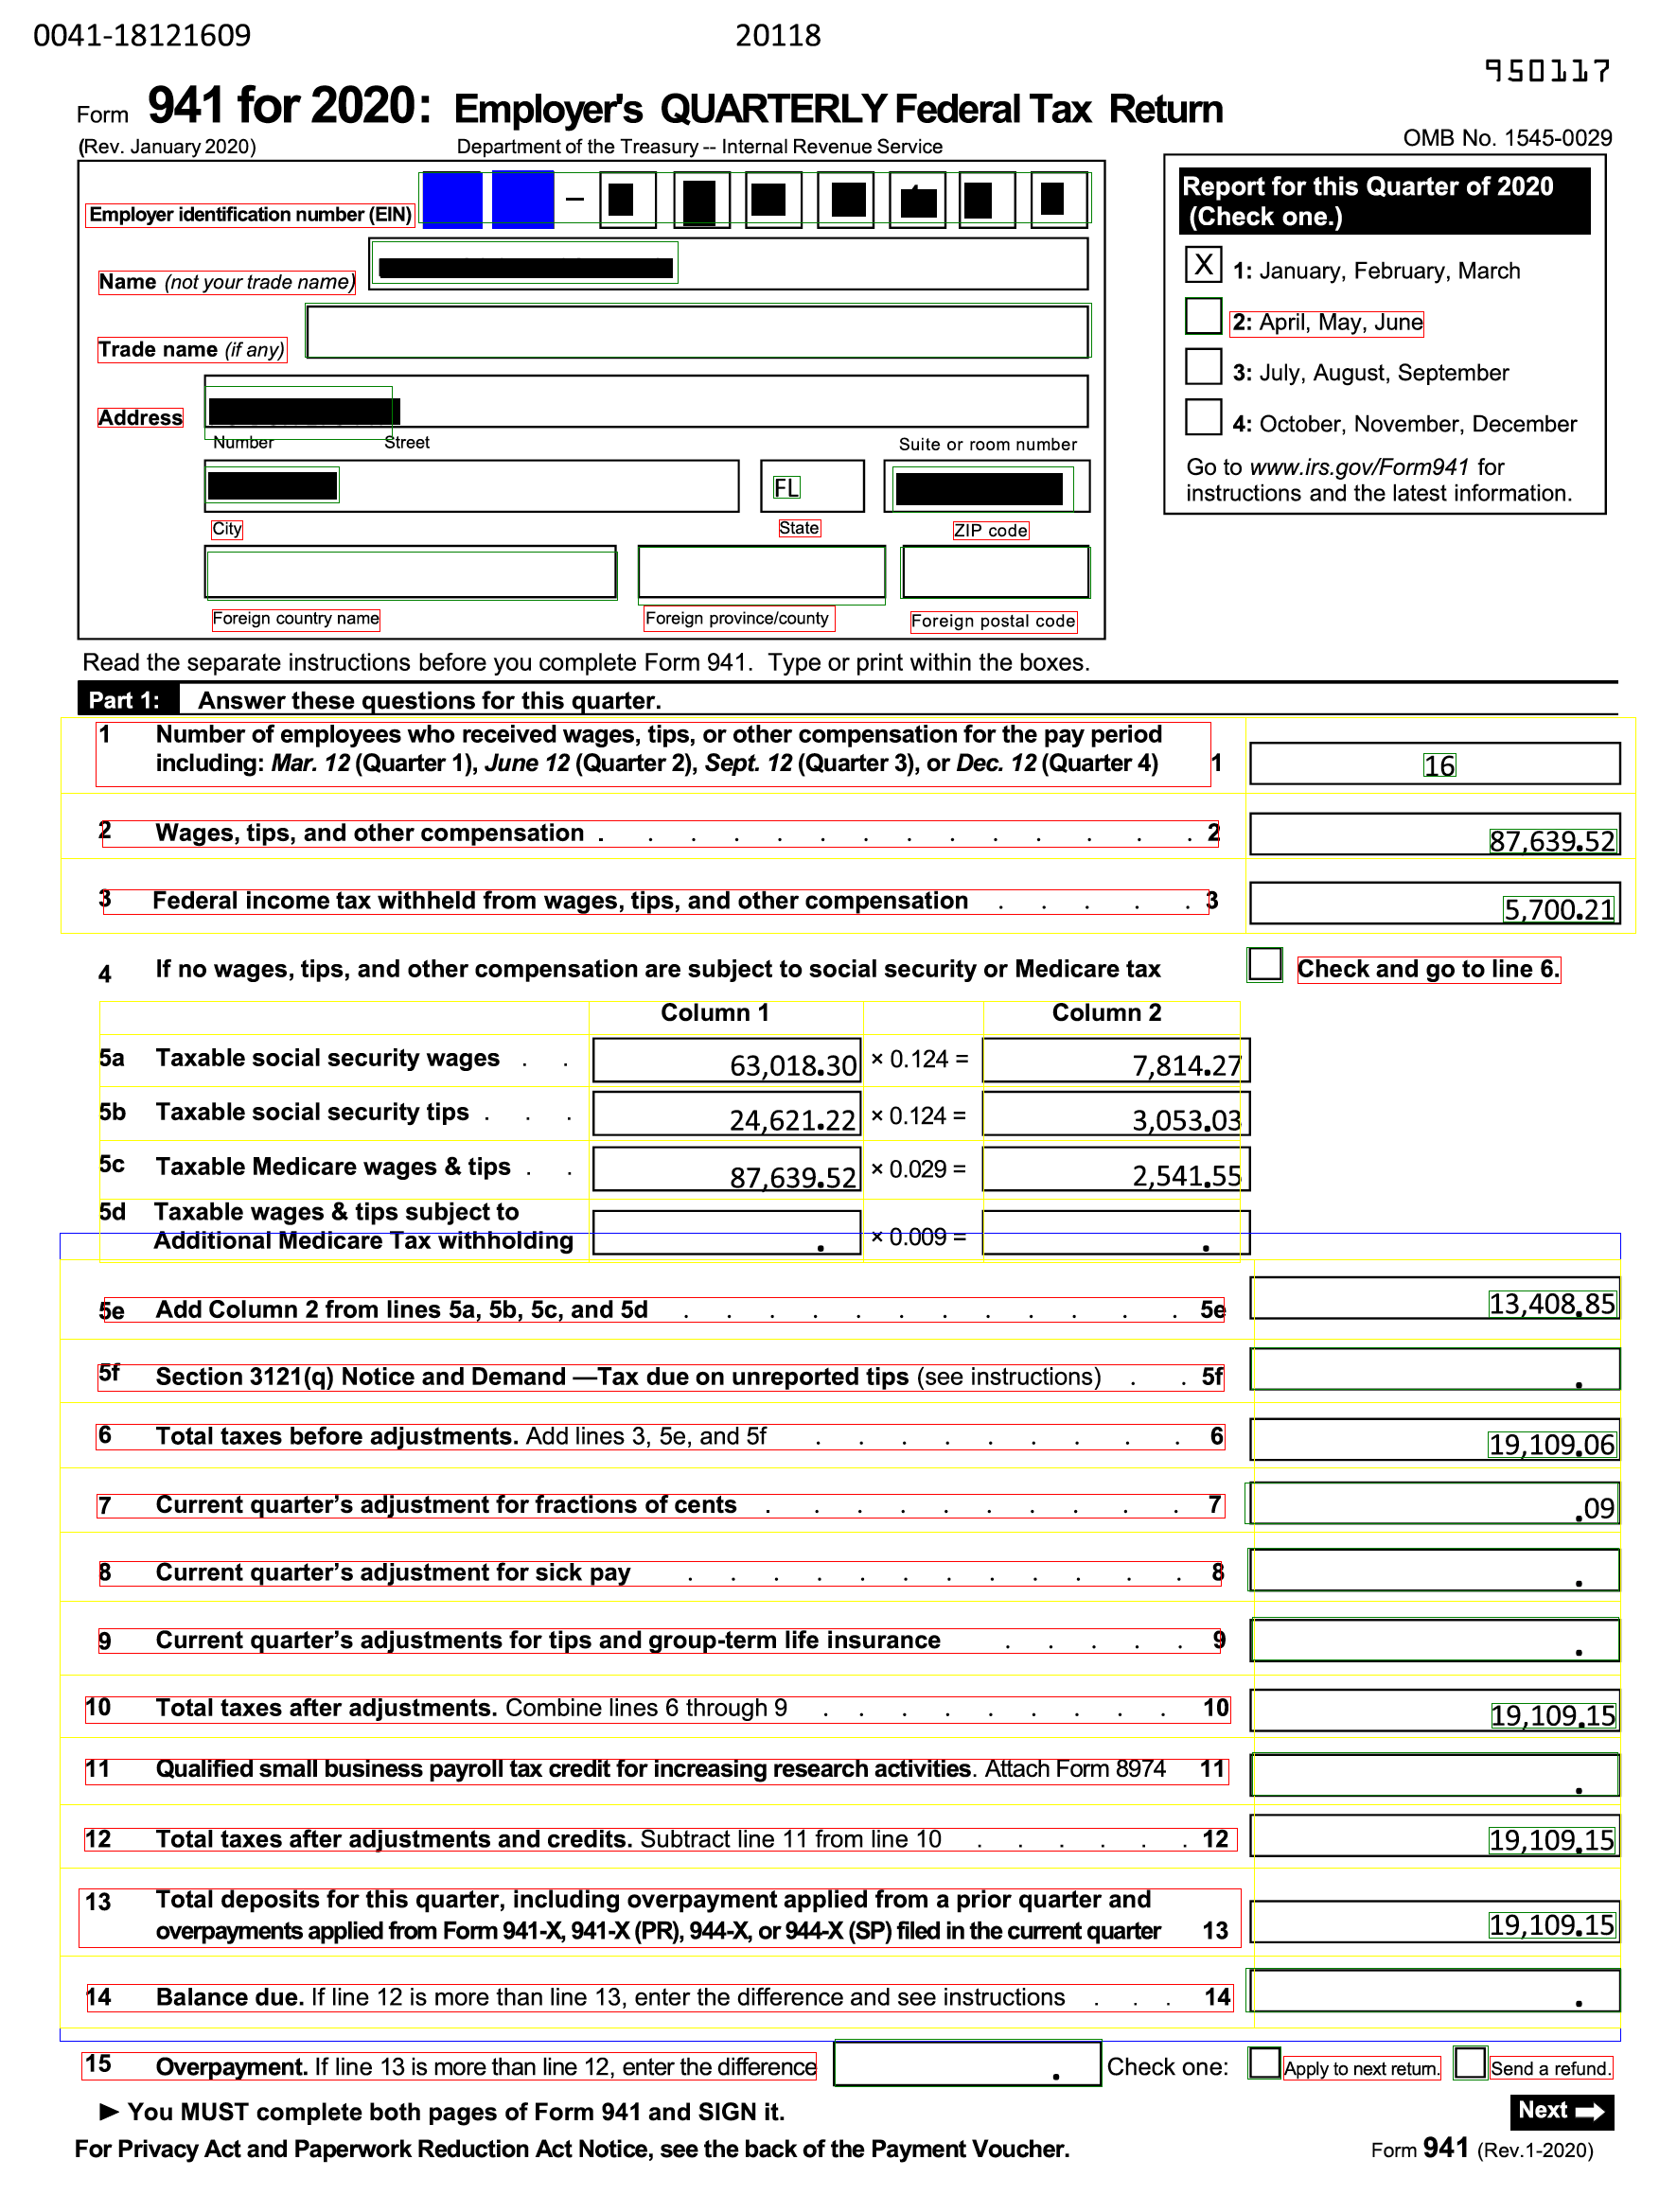

In [29]:
image

## Example code: Detect text

In [26]:
#Detects text in a document stored in an S3 bucket. Display polygon box around text and angled text 
import boto3
import io
from io import BytesIO
import sys

import psutil
import time

import math
from PIL import Image, ImageDraw, ImageFont


# Displays information about a block returned by text detection and text analysis
def DisplayBlockInformation(block):
    print('Id: {}'.format(block['Id']))
    if 'Text' in block:
        print('    Detected: ' + block['Text'])
    print('    Type: ' + block['BlockType'])
   
    if 'Confidence' in block:
        print('    Confidence: ' + "{:.2f}".format(block['Confidence']) + "%")

    if block['BlockType'] == 'CELL':
        print("    Cell information")
        print("        Column:" + str(block['ColumnIndex']))
        print("        Row:" + str(block['RowIndex']))
        print("        Column Span:" + str(block['ColumnSpan']))
        print("        RowSpan:" + str(block['ColumnSpan']))    
    
    if 'Relationships' in block:
        print('    Relationships: {}'.format(block['Relationships']))
    print('    Geometry: ')
    print('        Bounding Box: {}'.format(block['Geometry']['BoundingBox']))
    print('        Polygon: {}'.format(block['Geometry']['Polygon']))
    
    if block['BlockType'] == "KEY_VALUE_SET":
        print ('    Entity Type: ' + block['EntityTypes'][0])
    if 'Page' in block:
        print('Page: ' + block['Page'])
    print()

def process_text_detection(bucket, document):

    
    #Get the document from S3
    s3_connection = boto3.resource('s3')
                          
    s3_object = s3_connection.Object(bucket,document)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

   
    # Detect text in the document
    
    client = boto3.client('textract')
    #process using image bytes                      
    #image_binary = stream.getvalue()
    #response = client.detect_document_text(Document={'Bytes': image_binary})

    #process using S3 object
    response = client.detect_document_text(
        Document={'S3Object': {'Bucket': bucket, 'Name': document}})

    #Get the text blocks
    blocks=response['Blocks']
    width, height =image.size  
    draw = ImageDraw.Draw(image)  
    print ('Detected Document Text')
   
    # Create image showing bounding box/polygon the detected lines/text
    for block in blocks:
            print('Type: ' + block['BlockType'])
            if block['BlockType'] != 'PAGE':
                print('Detected: ' + block['Text'])
                print('Confidence: ' + "{:.2f}".format(block['Confidence']) + "%")

            print('Id: {}'.format(block['Id']))
            if 'Relationships' in block:
                print('Relationships: {}'.format(block['Relationships']))
            print('Bounding Box: {}'.format(block['Geometry']['BoundingBox']))
            print('Polygon: {}'.format(block['Geometry']['Polygon']))
            print()
            draw=ImageDraw.Draw(image)
            # Draw WORD - Green -  start of word, red - end of word
            if block['BlockType'] == "WORD":
                draw.line([(width * block['Geometry']['Polygon'][0]['X'],
                height * block['Geometry']['Polygon'][0]['Y']),
                (width * block['Geometry']['Polygon'][3]['X'],
                height * block['Geometry']['Polygon'][3]['Y'])],fill='green',
                width=2)
            
                draw.line([(width * block['Geometry']['Polygon'][1]['X'],
                height * block['Geometry']['Polygon'][1]['Y']),
                (width * block['Geometry']['Polygon'][2]['X'],
                height * block['Geometry']['Polygon'][2]['Y'])],
                fill='red',
                width=2)    

                 
            # Draw box around entire LINE  
            if block['BlockType'] == "LINE":
                points=[]

                for polygon in block['Geometry']['Polygon']:
                    points.append((width * polygon['X'], height * polygon['Y']))

                draw.polygon((points), outline='black')    
  
                # Uncomment to draw bounding box
                #box=block['Geometry']['BoundingBox']                    
                #left = width * box['Left']
                #top = height * box['Top']           
                #draw.rectangle([left,top, left + (width * box['Width']), top +(height * box['Height'])],outline='black') 


    # Display the image
    image.show()
    # display image for 10 seconds

    
    return len(blocks)

def main():

    bucket='adptextractpoc'
    document = '941_2020.png'
    block_count=process_text_detection(bucket,document)
    print("Blocks detected: " + str(block_count))
    
if __name__ == "__main__":
    main()


Detected Document Text
Type: PAGE
Id: 744b10ae-4144-4f89-a892-a541491362b1
Relationships: [{'Type': 'CHILD', 'Ids': ['249c98d6-c3e8-4b90-9b17-fdddcd7d375b', '7c820617-6abf-4086-8621-bce1b2cae55f', 'bd29ed4c-57e6-4691-9f82-225721bd8994', 'badcc4bb-a049-4711-9fc1-e0d5d35fac03', '3b921a6a-60e4-4925-b537-6e7feddc1218', '6a06fe1b-4db5-4d18-9cdb-16a91764b6f7', 'bdbe1a40-722f-4202-9d8b-1f10eef388c9', '16dce50a-31f8-4cac-a68e-a29a5a60eba0', 'cb903032-ffce-4868-b3a2-f2f88c2f59df', '03b5bc6e-3a13-4b48-a990-89c4060a27e5', '049cda43-772f-41ad-9731-aaa2176b36bc', '9cb0a959-7ad7-4d48-a5a7-8c0e61224ef5', '8c2375b1-7cac-433f-87f6-abfb24109de6', 'a0c4ee74-1d2a-473d-bb89-a2eb0f3ecae9', '8f22050c-3fea-4765-a660-30c362bde4a1', 'c1b43621-6ca9-4735-b971-12c5bea9f968', '4bdde1fa-36d9-43ec-9667-5254a0786d85', 'c247196f-0d9c-47c5-b003-91aef4bcd723', 'ec308c4f-f62b-4a08-bea8-0a097831bcf4', '0a53728d-5d63-418d-9b3f-487491740e02', '9bc2728b-0043-46d3-8906-cd5d53cbe5d1', '6d625d30-6668-429a-a3f7-8b6850e70981', 'db

Detected: wages,
Confidence: 99.86%
Id: d50e2929-1f00-473d-960b-b128854cc901
Bounding Box: {'Width': 0.04907893016934395, 'Height': 0.010187169536948204, 'Left': 0.12660574913024902, 'Top': 0.43409863114356995}
Polygon: [{'X': 0.12660574913024902, 'Y': 0.43409863114356995}, {'X': 0.17568467557430267, 'Y': 0.43409863114356995}, {'X': 0.17568467557430267, 'Y': 0.4442858099937439}, {'X': 0.12660574913024902, 'Y': 0.4442858099937439}]

Type: WORD
Detected: tips,
Confidence: 99.89%
Id: 20822d03-38ff-42cb-a2bd-4db8bae637df
Bounding Box: {'Width': 0.030613569542765617, 'Height': 0.011731879785656929, 'Left': 0.17836515605449677, 'Top': 0.432486891746521}
Polygon: [{'X': 0.17836515605449677, 'Y': 0.432486891746521}, {'X': 0.20897872745990753, 'Y': 0.432486891746521}, {'X': 0.20897872745990753, 'Y': 0.44421878457069397}, {'X': 0.17836515605449677, 'Y': 0.44421878457069397}]

Type: WORD
Detected: and
Confidence: 99.87%
Id: 17f3d3a5-bea7-41fc-a9a2-367575fd4090
Bounding Box: {'Width': 0.0270148105

## Test of Tabula

In [26]:
import tabula

# Read pdf into list of DataFrame
df = tabula.read_pdf(pdffile, pages='all')

In [27]:
len(df)

4

In [32]:
df[1]

,1,Total Wages Paid THIS QUARTER,"2,769.23",Unnamed: 0,For Quarter Ending Date Due,Unnamed: 1
0,NaN,"Wages in excess of $8 , 0 0 0for",NaN,NaN,NaN,NaN
1,2.0,Calendar year paid to individual,NaN,06,30 2019 07 31 2019,NaN
2,NaN,workers during THIS QUARTER.,NaN,NaN,NaN,NaN
3,NaN,NaN,.00,NaN,NaN,NaN
4,3.0,Net Taxable Wages,NaN,Employer Account Number,For State Use Only,NaN
5,NaN,(Item 1 minus Item 2),"2,769.23",(Must Be 1st 10 Digits),NaN,NaN
6,4.0,Employer Tax@ 2.7000 %,74.77,0111111111,NaN,NaN
7,NaN,NaN,NaN,NaN,Liability Dates,NaN
8,5.0,Employee Tax @ %,NaN,NaN,EMPLOYER EMPLOYEE,NaN
9,6.0,Employment Security @ .0000 %,.00,NaN,NaN,NaN
